### Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "intro_to_ANN"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


## The Perceptron

The Perceptron is one of the simplest ANN architectures, invented in 1957 by Frank Rosenblatt. It is based on a slightly different artificial neuron (see Figure 10-4) called a threshold logic unit (TLU), or sometimes a linear threshold unit (LTU)

The most common step function used in Perceptrons is the Heaviside step function (see Equation 10-1). Sometimes the sign function is used instead.

A single TLU can be used for `simple linear binary classification`. It computes a linear combination of the inputs, and if the result exceeds a threshold, it outputs the positive class. Otherwise it outputs the negative class (just like a Logistic Regression or linear SVM classifier). You could, for example, use a single TLU to classify iris flowers based on petal length and width (also adding an extra bias feature $x_0 = 1$, just like we did in previous chapters). Training a TLU in this case means finding the right values for $w_0$, $w_1$, and $w_2$ (the training algorithm is discussed shortly).

A Perceptron is simply composed of a single layer of TLUs, with each TLU connected to all the inputs. When all the neurons in a layer are connected to every neuron in the previous layer (i.e., its input neurons), the layer is called a **`fully connected layer, or a dense layer.`** The inputs of the Perceptron are fed to special passthrough neurons called input neurons: they output whatever input they are fed. All the input neurons form the input layer. Moreover, an extra bias feature is generally added ($x_0 = 1$): it is typically represented using a special type of neuron called a bias neuron, which outputs 1 all the time. A Perceptron with two inputs and three outputs is represented in Figure 10-5. **This Perceptron can classify instances simultaneously into three different binary classes, which makes it a `multioutput classifier`**.

The decision boundary of each output neuron is linear, so Perceptrons are incapable of learning complex patterns (just like Logistic Regression classifiers). However, if the training instances are linearly separable, Rosenblatt demonstrated that this algorithm would converge to a solution.8 This is called the `Perceptron convergence theorem`.
<br>

Scikit-Learn provides a **_Perceptron_** class that implements a single-TLU network. It can be used pretty much as you would expect—for example, on the iris dataset

In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

In [2]:
iris = load_iris()

In [3]:
X = iris.data[:, (2, 3)] # petal length, petal width
y = (iris.target == 0).astype(np.int) # Iris setosa?

In [40]:
X.shape, y.shape

((150, 2), (150,))

In [7]:
per_clf = Perceptron()
per_clf.fit(X, y)

Perceptron()

In [8]:
y_pred = per_clf.predict([[2, 0.5]])

In [9]:
y_pred

array([0])

`You may have noticed that the Perceptron learning algorithm strongly resembles Stochastic Gradient Descent. In fact, Scikit-Learn’s Perceptron class is equivalent to using an SGDClassifier with the following hyperparameters: loss="perceptron", learning_rate="constant", eta0=1 (the learning rate), and penalty=None (no regularization).`
<br>

`Note that contrary to Logistic Regression classifiers, Perceptrons do not output a class probability; rather, they make predictions based on a hard threshold. This is one reason to prefer Logistic Regression over Perceptrons.`

In [14]:
per_clf.intercept_, per_clf.coef_

(array([2.]), array([[-0.7, -1.2]]))

Saving figure perceptron_iris_plot


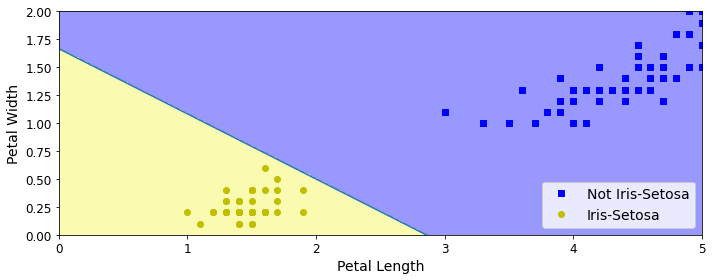

In [71]:
a = - per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = - per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

X0, X1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )

X_new = np.c_[X0.ravel(), X1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(X0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y == 0, 0], X[y == 0, 1], 'bs', label='Not Iris-Setosa')
plt.plot(X[y == 1, 0], X[y == 1, 1], 'yo', label='Iris-Setosa')

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b])

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(X0, X1, zz, cmap=custom_cmap)
plt.xlabel('Petal Length', fontsize=14)
plt.ylabel('Petal Width', fontsize=14)

plt.legend(loc='lower right', fontsize=14)
plt.axis(axes)

save_fig("perceptron_iris_plot")
plt.show()

In [47]:
X[0, :]

array([1.4, 0.2])

In [42]:
a, b, X0.shape, X1.shape, X0.ravel().shape, X_new.shape, y_predict.shape, zz.shape

(-0.5833333333333338,
 array([1.66666667]),
 (200, 500),
 (200, 500),
 (100000,),
 (100000, 2),
 (100000,),
 (200, 500))

## The Multilayer Perceptron and Backpropagation

An MLP is composed of one (passthrough) _input layer_, one or more layers of TLUs, called _hidden layers_, and one final layer of TLUs called the _output layer_ (see Figure 10-7). The layers close to the input layer are usually called the _lower layers_, and the ones close to the outputs are usually called the _upper layers_. Every layer except the output layer includes a bias neuron and is fully connected to the next layer.

![Architecture of a Multilayer Perceptron with two inputs, one hidden layer of four neurons, and three output neurons (the bias neurons are shown here, but usually they are implicit)](images/intro_to_ANN/architecture_of_multilayer_perceptron.png)

## NOTE

> The signal flows only in one direction (from the inputs to the outputs), so this architecture is an example of a **`feedforward neural network (FNN).`**

When an ANN contains a deep stack of hidden layers, it is called a **`deep neural network (DNN)`**.

### The Backpropagation training algorithm, 

It is still used today. In short, it is `Gradient Descent` (introduced in Chapter 4) using an efficient technique for **computing the gradients automatically**: in just two passes through the network (_one forward, one backward_), the backpropagation algorithm is able to compute the gradient of the network’s error with regard to every single model parameter. In other words, it can find out how each connection weight and each bias term should be tweaked in order to reduce the error. Once it has these gradients, it just performs a regular Gradient Descent step, and the whole process is repeated until the network converges to the solution.

## NOTE

> **Automatically computing gradients is called `automatic differentiation, or autodiff`. There are various autodiff techniques, with different pros and cons. `The one used by backpropagation is called reverse-mode autodiff`. It is fast and precise, and is well suited when the function to differentiate has many variables (e.g., connection weights) and few outputs (e.g., one loss). If you want to learn more about autodiff, check out Appendix D.**

`Let’s run through this algorithm in a bit more detail:`
* It handles one mini-batch at a time (for example, containing 32 instances each), and it goes through the full training set multiple times. Each pass is called an **`epoch`**.
* Each mini-batch is passed to the network’s input layer, which sends it to the first hidden layer. The algorithm then computes the output of all the neurons in this layer (for every instance in the mini-batch). The result is passed on to the next layer, its output is computed and passed to the next layer, and so on until we get the output of the last layer, the output layer. **`This is the forward pass`**: **`it is exactly like making predictions, except all intermediate results are preserved since they are needed for the backward pass.`**
* Next, the algorithm measures the network’s output error (i.e., it uses a `loss function that compares the desired output and the actual output of the network`\, and returns some measure of the error`).
* Then it computes how much each output connection contributed to the error. This is done analytically by applying the chain rule (perhaps the most fundamental rule in calculus), which makes this step fast and precise.
* The algorithm then measures how much of these error contributions came from each connection in the layer below, again using the chain rule, working backward until the algorithm reaches the input layer. As explained earlier, this reverse pass efficiently measures the error gradient across all the connection weights in the network by propagating the error gradient backward through the network (hence the name of the algorithm).
* Finally, the algorithm performs a Gradient Descent step to tweak all the connection weights in the network, using the error gradients it just computed.

<br>

> **_`This algorithm is so important that it’s worth summarizing it again: for each training instance, the backpropagation algorithm first makes a prediction (forward pass) and measures the error, then goes through each layer in reverse to measure the error contribution from each connection (reverse pass), and finally tweaks the connection weights to reduce the error (Gradient Descent step).`_**

## WARNING

> It is important to initialize all the hidden layers’ connection weights randomly, or else training will fail. For example, if you initialize all weights and biases to zero, then all neurons in a given layer will be perfectly identical, and thus backpropagation will affect them in exactly the same way, so they will remain identical. In other words, despite having hundreds of neurons per layer, your model will act as if it had only one neuron per layer: it won’t be too smart. If instead you randomly initialize the weights, you break the symmetry and allow backpropagation to train a diverse team of neurons.

### Activation Functions

In order for this algorithm to work properly, its authors made a key change to the MLP’s architecture: they replaced the step function with the logistic (sigmoid) function, $σ(z) = 1 / (1 + exp(–z))$. **`This was essential because the step function contains only flat segments, so there is no gradient to work with (Gradient Descent cannot move on a flat surface), while the logistic function has a well-defined nonzero derivative everywhere, allowing Gradient Descent to make some progress at every step.`** In fact, the backpropagation algorithm works well with many other activation functions, not just the logistic function. Here are two other popular choices:
<br>

* The `hyperbolic tangent` function: $tanh(z) = 2σ(2z) – 1$
    * Just like the logistic function, this activation function is S-shaped, continuous, and differentiable, but its output value ranges from –1 to 1 (instead of 0 to 1 in the case of the logistic function). That range tends to make each layer’s output more or less centered around 0 at the beginning of training, which often helps speed up convergence.
* The `Rectified Linear Unit` function: $ReLU(z) = max(0, z)$
    * The ReLU function is continuous but unfortunately not differentiable at $z= 0$ (the slope changes abruptly, which can make Gradient Descent bounce around), and its derivative is $0$ for $z < 0$. In practice, however, it works very well and has the advantage of being fast to compute, so it has become the default. Most importantly, the fact that it does not have a maximum output value helps reduce some issues during Gradient Descent (we will come back to this in Chapter 11).

_**`These popular activation functions and their derivatives are represented in Figure 10-8 or below. But wait! Why do we need activation functions in the first place? Well, if you chain several linear transformations, all you get is a linear transformation. For example, if` $f(x) = 2x + 3$ `and` $g(x) = 5x – 1$, `then chaining these two linear functions gives you another linear function:` $f(g(x)) = 2(5x – 1) + 3 = 10x + 1$. `So if you don’t have some nonlinearity between layers, then even a deep stack of layers is equivalent to a single layer, and you can’t solve very complex problems with that. Conversely, a large enough DNN with nonlinear activations can theoretically approximate any continuous function.`**_

In [4]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

def relu(z):
    return np.maximum(z, 0)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

Saving figure activation_functions_plot


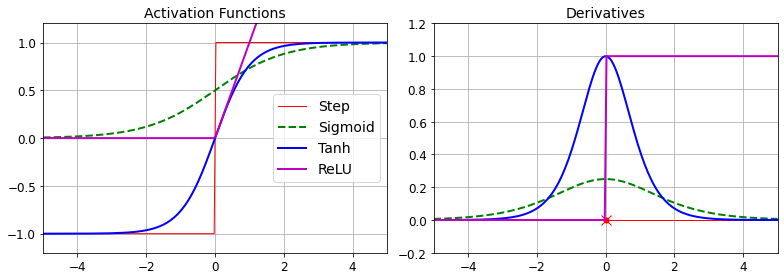

In [105]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(z, np.sign(z), 'r-', label='Step', linewidth=1)
plt.plot(z, sigmoid(z), 'g--', label='Sigmoid', linewidth=2)
plt.plot(z, np.tanh(z), 'b-', label='Tanh', linewidth=2)
plt.plot(z, relu(z), 'm-', label='ReLU', linewidth=2)
plt.grid(True)
plt.legend(loc='center right', fontsize=14)
plt.title('Activation Functions', fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), 'r-', label='Step', linewidth=1)
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), 'g--', label='Sigmoid', linewidth=2)
plt.plot(z, derivative(np.tanh, z), 'b-', label='Tanh', linewidth=2)
plt.plot(z, derivative(relu, z), 'm-', label='ReLU', linewidth=2)
plt.grid(True)
plt.axis([-5, 5, -0.2, 1.2])
plt.title('Derivatives', fontsize=14)

save_fig("activation_functions_plot")
plt.show()

In [2]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)

def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

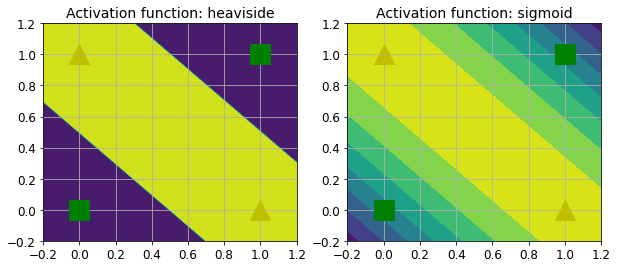

In [5]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)

OK! You know where neural nets came from, what their architecture is, and how to compute their outputs. You’ve also learned about the backpropagation algorithm. But what exactly can you do with them?

### Regression MLPs

First, MLPs can be used for regression tasks. If you want to predict a single value (e.g., the price of a house, given many of its features), then you just need a single output neuron: its output is the predicted value. For multivariate regression (i.e., to predict multiple values at once), you need one output neuron per output dimension. For example, to locate the center of an object in an image, you need to predict 2D coordinates, so you need two output neurons. If you also want to place a bounding box around the object, then you need two more numbers: the width and the height of the object. So, you end up with four output neurons. <br>

_**In general, when building an MLP for regression, you do not want to use any activation function for the output neurons, so they are free to output any range of values. If you want to guarantee that the output will always be positive, then you can use the ReLU activation function in the output layer. Alternatively, you can use the `softplus` activation function, which is a smooth variant of ReLU: $softplus(z) = log(1 + exp(z))$. It is close to $0$ when $z$ is negative, and close to $z$ when $z$ is positive. Finally, if you want to guarantee that the predictions will fall within a given range of values, then you can use the logistic function or the hyperbolic tangent, and then scale the labels to the appropriate range: $0$ to $1$ for the logistic function and $–1$ to $1$ for the hyperbolic tangent.**_

**_The loss function to use during training is typically the `mean squared error`, but if you have `a lot of outliers` in the training set, you may prefer to use the `mean absolute error` instead. Alternatively, you can use the `Huber` loss, which is a combination of both._**

### TIP

> The Huber loss is quadratic when the error is smaller than a threshold $δ$ (typically $1$) but linear when the error is larger than $δ$. The linear part makes it less sensitive to outliers than the mean squared error, and the quadratic part allows it to converge faster and be more precise than the mean absolute error.

![Typical regression MLP architecture](images/intro_to_ANN/regression_mlp_architecture.png)

## Classification MLPs

MLPs can also be used for classification tasks. For a **`binary classification`** problem, you just need a single output neuron using the logistic activation function: the output will be a number between 0 and 1, which you can interpret as the estimated probability of the positive class. The estimated probability of the negative class is equal to one minus that number.
<br>

MLPs can also easily handle **`multilabel binary classification`** tasks (see Chapter 3). For example, you could have an email classification system that predicts whether each incoming email is ham or spam, and simultaneously predicts whether it is an urgent or nonurgent email. In this case, you would need two output neurons, both using the logistic activation function: the first would output the probability that the email is spam, and the second would output the probability that it is urgent. More generally, you would dedicate one output neuron for each positive class. Note that the output probabilities do not necessarily add up to 1. This lets the model output any combination of labels: you can have nonurgent ham, urgent ham, nonurgent spam, and perhaps even urgent spam (although that would probably be an error).
<br>

If each instance can belong only to a single class, out of three or more possible classes (e.g., classes 0 through 9 for digit image classification), then you need to have one output neuron per class, and you should use the softmax activation function for the whole output layer (see Figure 10-9). The softmax function (introduced in Chapter 4) will ensure that all the estimated probabilities are between 0 and 1 and that they add up to 1 (which is required if the classes are exclusive). This is called **`multiclass classification`**.
<br>

![A modern MLP (including ReLU and softmax) for classification](images/intro_to_ANN/classification_mlp.png)

Regarding the loss function, since we are predicting probability distributions, the **`cross-entropy loss`** (also called the log loss, see Chapter 4) is generally a good choice.
<br>

![summarizes the typical architecture of a classification MLP](images/intro_to_ANN/classification_mlp_architecture.png)

# Implementing MLPs with Keras

Keras is a high-level Deep Learning API that allows you to easily build, train, evaluate, and execute all sorts of neural networks. Its documentation (or specification) is available at https://keras.io/. The reference implementation, also called Keras, was developed by François Chollet as part of a research project13 and was released as an open source project in March 2015. It quickly gained popularity, owing to its ease of use, flexibility, and beautiful design. To perform the heavy computations required by neural networks, this reference implementation relies on a computation backend.` At present, you can choose from three popular open source Deep Learning libraries: TensorFlow, Microsoft Cognitive Toolkit (CNTK), and Theano`. Therefore, to avoid any confusion, we will refer to this reference implementation as multibackend Keras.

Since late 2016, other implementations have been released. You can now `run Keras on Apache MXNet, Apple’s Core ML, JavaScript or TypeScript (to run Keras code in a web browser), and PlaidML (which can run on all sorts of GPU devices, not just Nvidia)`. Moreover, TensorFlow itself now comes bundled with its own Keras implementation, tf.keras. It only supports TensorFlow as the backend, but it has the advantage of offering some very useful extra features (see Figure 10-10): for example, it supports TensorFlow’s Data API, which makes it easy to load and preprocess data efficiently. For this reason, we will use tf.keras in this book. However, in this chapter we will not use any of the TensorFlow-specific features, so the code should run fine on other Keras implementations as well (at least in Python), with only minor modifications, such as changing the imports. <br>

![Two implementations of the Keras API](images/intro_to_ANN/keras_api_implementation.png)

The most popular Deep Learning library, after Keras and TensorFlow, is Facebook’s `PyTorch` library. The good news is that its API is quite similar to Keras’s (in part because both APIs were inspired by Scikit-Learn and Chainer), so once you know Keras, it is not difficult to switch to PyTorch, if you ever want to. PyTorch’s popularity grew exponentially in 2018, largely thanks to its simplicity and excellent documentation, which were not TensorFlow 1.x’s main strengths. However, TensorFlow 2 is arguably just as simple as PyTorch, as it has adopted Keras as its official high-level API and its developers have greatly simplified and cleaned up the rest of the API. The documentation has also been completely reorganized, and it is much easier to find what you need now. Similarly, PyTorch’s main weaknesses (e.g., limited portability and no computation graph analysis) have been largely addressed in PyTorch 1.0. Healthy competition is beneficial to everyone.

In [2]:
# import keras and tensorflow
import tensorflow as tf
from tensorflow import keras

In [3]:
tf.__version__

'2.4.1'

In [4]:
keras.__version__

'2.4.0'

## Building an Image Classifier Using the Sequential API

First, we need to load a dataset. In this chapter we will tackle Fashion MNIST, which is a drop-in replacement of MNIST (introduced in Chapter 3). It has the exact same format as MNIST (70,000 grayscale images of 28 × 28 pixels each, with 10 classes), but the images represent fashion items rather than handwritten digits, so each class is more diverse, and the problem turns out to be significantly more challenging than MNIST. For example, a simple linear model reaches about 92% accuracy on MNIST, but only about 83% on Fashion MNIST.

In [5]:
# load dataset
fashion_mnist = keras.datasets.fashion_mnist

In [6]:
type(fashion_mnist)

module

In [7]:
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

When loading MNIST or Fashion MNIST using Keras rather than Scikit-Learn, one important difference is that every image is represented as a 28 × 28 array rather than a 1D array of size 784. Moreover, the pixel intensities are represented as integers (from 0 to 255) rather than floats (from 0.0 to 255.0). Let’s take a look at the shape and data type of the training set:

In [8]:
X_train_full.shape, y_train_full.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [9]:
type(X_train_full), type(y_train_full)

(numpy.ndarray, numpy.ndarray)

In [10]:
np.unique(y_train_full)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

Each pixel intensity is represented as a byte (0 to 255):

In [11]:
X_train_full.dtype

dtype('uint8')

Note that the dataset is already split into a training set and a test set, but there is no validation set, so we’ll create one now. Additionally, since we are going to train the neural network using Gradient Descent, we must scale the input features. For simplicity, we’ll scale the pixel intensities down to the 0–1 range by dividing them by 255.0 (this also converts them to floats):

In [12]:
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

In [13]:
X_valid.shape, y_valid.shape, X_train.shape, y_train.shape

((5000, 28, 28), (5000,), (55000, 28, 28), (55000,))

With MNIST, when the label is equal to 5, it means that the image represents the handwritten digit 5. Easy. For Fashion MNIST, however, we need the list of class names to know what we are dealing with:

In [14]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [15]:
class_names[y_train[0]]

'Coat'

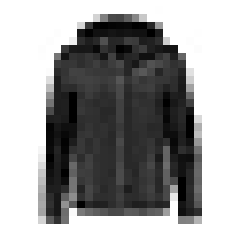

In [16]:
plt.imshow(X_train[0], cmap='binary')
plt.axis('off')
plt.show()

Let's take a look at a sample of the images in the dataset:

Saving figure fashion_mnist_plot


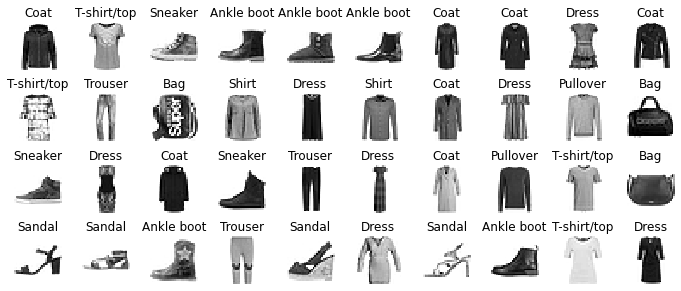

In [17]:
n_rows = 4
n_cols = 10

plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = row * n_cols + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap='binary', interpolation='nearest')
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
        
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

### Creating the model using Sequential API

Now let’s build the neural network! Here is a classification MLP with two hidden layers:

In [18]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

Let’s go through this code line by line:

* The first line creates a Sequential model. This is the simplest kind of Keras model for neural networks that are just composed of a single stack of layers connected sequentially. This is called the Sequential API.

* Next, we build the first layer and add it to the model. It is a Flatten layer whose role is to convert each input image into a 1D array: if it receives input data X, it computes X.reshape(-1, 1). This layer does not have any parameters; it is just there to do some simple preprocessing. Since it is the first layer in the model, you should specify the input_shape, which doesn’t include the batch size, only the shape of the instances. Alternatively, you could add a keras.layers.InputLayer as the first layer, setting input_shape=[28,28].

* Next we add a Dense hidden layer with 300 neurons. It will use the ReLU activation function. Each Dense layer manages its own weight matrix, containing all the connection weights between the neurons and their inputs. It also manages a vector of bias terms (one per neuron). When it receives some input data, it computes Equation 10-2.

* Then we add a second Dense hidden layer with 100 neurons, also using the ReLU activation function.

* Finally, we add a Dense output layer with 10 neurons (one per class), using the softmax activation function (because `the classes are exclusive`).

In [19]:
model.output_shape

(None, 10)

Instead of adding the layers one by one as we just did, you can pass a list of layers when creating the Sequential model:

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

The model’s `summary()` method displays all the model’s layers, including each layer’s name (which is automatically generated unless you set it when creating the layer), its output shape (`None means the batch size can be anything`), and its number of parameters. The summary ends with the total number of parameters, including trainable and non-trainable parameters. Here we only have trainable parameters (we will see examples of non-trainable parameters in Chapter 11):

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


Note that Dense layers often have a lot of parameters. For example, the first hidden layer has 784 × 300 connection weights, plus 300 bias terms, which adds up to 235,500 parameters! This gives the model quite a lot of flexibility to fit the training data, but it also means that the model runs the risk of overfitting, especially when you do not have a lot of training data. We will come back to this later.

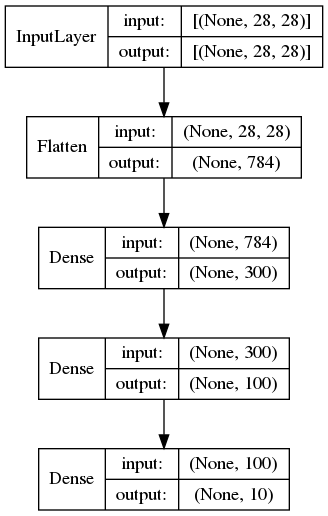

In [28]:
keras.utils.plot_model(model, 'images/intro_to_ANN/my_fashion_mnish_model.png', show_shapes=True, show_layer_names=False)

You can easily get a model’s list of layers, to fetch a layer by its index, or you can fetch it by name:

In [29]:
model.layers

In [30]:
hidden1 = model.layers[1]

In [31]:
hidden1.name

'dense'

In [32]:
model.get_layer('dense') is hidden1

True

In [33]:
model.layers[2].name

'dense_1'

In [34]:
model.get_layer(model.layers[2].name) is model.layers[2]

True

All the parameters of a layer can be accessed using its **`get_weights()`** and **`set_weights()`** methods. For a Dense layer, this includes both the connection weights and the bias terms:

In [35]:
weights, biases = hidden1.get_weights()

In [36]:
weights.shape, biases.shape

((784, 300), (300,))

In [ ]:
biases

Notice that the Dense layer initialized the connection weights randomly (which is needed to break symmetry, as we discussed earlier), and the biases were initialized to zeros, which is fine. If you ever want to use a different initialization method, you can set `kernel_initializer` (kernel is another name for the matrix of connection weights) or `bias_initializer` when creating the layer. We will discuss initializers further in Chapter 11, but if you want the full list, see https://keras.io/initializers/.

## NOTE

> The shape of the weight matrix depends on the number of inputs. This is why it is recommended to specify the input_shape when creating the first layer in a Sequential model. However, if you do not specify the input shape, it’s OK: Keras will simply wait until it knows the input shape before it actually builds the model. This will happen either when you feed it actual data (e.g., during training), or when you call its `build()` method. Until the model is really built, the layers will not have any weights, and you will not be able to do certain things (such as print the model summary or save the model). So, if you know the input shape when creating the model, it is best to specify it.

### Compiling the model

After a model is created, you must call its `compile()` method to specify the loss function and the optimizer to use. Optionally, you can specify a list of extras metrics to compute during training and evaluation:

In [38]:
model.compile(loss='sparse_categorical_crossentropy', 
             optimizer='sgd',
             metrics=['accuracy'])

This is equivalent to:

```python
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

### NOTE

> Using `loss="sparse_categorical_crossentropy"` is equivalent to using `loss=keras.losses.sparse_categorical_crossentropy`. Similarly, specifying `optimizer="sgd"` is equivalent to specifying `optimizer=keras.optimizers.SGD()`, and `metrics=["accuracy"]` is equivalent to `metrics=[keras.metrics.sparse_categorical_accuracy]` (when using this loss). We will use many other losses, optimizers, and metrics in this book; for the full lists, see https://keras.io/losses, https://keras.io/optimizers, and https://keras.io/metrics.

This code requires some explanation. First, we use the **_"sparse_categorical_crossentropy"_** loss because we have sparse labels (i.e., for each instance, there is just a target class index, from 0 to 9 in this case), and the classes are exclusive. If instead we had one target probability per class for each instance (such as one-hot vectors, e.g. [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.] to represent class 3), then we would need to use the **_"categorical_crossentropy"_** loss instead. <br>
**`If we were doing binary classification (with one or more binary labels), then we would use the "sigmoid" (i.e., logistic) activation function in the output layer instead of the "softmax" activation function, and we would use the "binary_crossentropy" loss.`**

### TIP

> If you want to convert sparse labels (i.e., class indices) to one-hot vector labels, use the _keras.utils.to_categorical()_ function. To go the other way round, use the _np.argmax()_ function with $axis=1$.

Regarding the `optimizer`, _**"sgd"**_ means that we will train the model using simple Stochastic Gradient Descent. In other words, Keras will perform the backpropagation algorithm described earlier (i.e., reverse-mode autodiff plus Gradient Descent). We will discuss more efficient optimizers in Chapter 11 (they improve the Gradient Descent part, not the autodiff).

### NOTE

> When using the `SGD` optimizer, it is important to tune the learning rate. So, you will generally want to use $optimizer=keras.optimizer.SGD(lr=???)$ to set the learning rate, rather than **optimizer='sgd'**, which defaults to $lr=0.01$.

Finally, since this is a classifier, it’s useful to measure its `"accuracy"` during training and evaluation.

### Training and evaluating the model

Now the model is ready to be trained. For this we simply need to call its $fit()$ method:

In [39]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 9s 4ms/step - loss: 1.0138 - accuracy: 0.6804 - val_loss: 0.5202 - val_accuracy: 0.8264
Epoch 2/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5023 - accuracy: 0.8239 - val_loss: 0.4498 - val_accuracy: 0.8466
Epoch 3/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4479 - accuracy: 0.8423 - val_loss: 0.4381 - val_accuracy: 0.8544
Epoch 4/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4182 - accuracy: 0.8528 - val_loss: 0.4102 - val_accuracy: 0.8644
Epoch 5/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3915 - accuracy: 0.8626 - val_loss: 0.3904 - val_accuracy: 0.8654
Epoch 6/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3856 - accuracy: 0.8633 - val_loss: 0.3874 - val_accuracy: 0.8634
Epoch 7/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3676 - accuracy: 0.8676 - val_loss: 0.3711 - val_accuracy:

We pass it the input features (X_train) and the target classes (y_train), as well as the number of epochs to train (or else it would default to just 1, which would definitely not be enough to converge to a good solution). We also pass a validation set (this is optional). Keras will measure the loss and the extra metrics on this set at the end of each epoch, which is very useful to see how well the model really performs. If the performance on the training set is much better than on the validation set, your model is probably overfitting the training set (or there is a bug, such as a data mismatch between the training set and the validation set).

And that’s it! The neural network is trained. At each epoch during training, Keras displays the number of instances processed so far (along with a progress bar), the mean training time per sample, and the loss and accuracy (or any other extra metrics you asked for) on both the training set and the validation set. `You can see that the training loss went down, which is a good sign, and the validation accuracy reached 89.68% after 30 epochs. That’s not too far from the training accuracy, so there does not seem to be much overfitting going on.`

### TIP

> Instead of passing a validation set using the *validation_data* argument, you could set *validation_split* to the ratio of the training set that you want Keras to use for validation. For example, *validation_split=0.1* tells Keras to use the last 10% of the data (before shuffling) for validation.

_**If the `training set was very skewed`, with some classes being overrepresented and others underrepresented, it would be useful to set the `class_weight` argument when calling the `fit()` method, which would give a `larger weight to underrepresented classes` and a `lower weight to overrepresented classes`. These weights would be used by Keras when computing the loss.**_<br>
_**If you need `per-instance weights`, set the `sample_weight` argument (it `supersedes class_weight`). `Per-instance weights could be useful if some instances were labeled by experts while others were labeled using a crowdsourcing platform: you might want to give more weight to the former`. You can also provide sample weights (but not class weights) for the validation set by adding them as a third item in the validation_data tuple.**_
<br>

The `fit()` method returns a `History` object containing the training parameters (`history.params`), the list of epochs it went through (`history.epoch`), and most importantly a dictionary (`history.history`) containing the `loss and extra metrics` it measured at the end of each epoch on the training set and on the validation set (if any). If you use this dictionary to create a pandas DataFrame and call its `plot()` method, you get the learning curves shown in Figure 10-12:

In [41]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [43]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [47]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Saving figure keras_learning_curves_plot


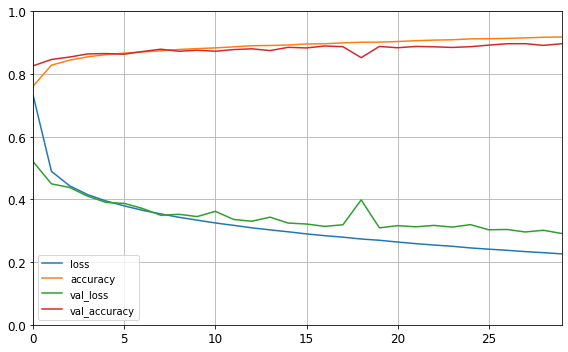

In [54]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid()
plt.gca().set_ylim(0, 1) 
plt.xlim((0, 29))
save_fig("keras_learning_curves_plot")
plt.show()

`Learning curves: the mean training loss and accuracy measured over each epoch, and the mean validation loss and accuracy measured at the end of each epoch`

**`You can see that both the training accuracy and the validation accuracy steadily increase during training, while the training loss and the validation loss decrease. Good! Moreover, the validation curves are close to the training curves, which means that there is not too much overfitting. In this particular case, the model looks like it performed better on the validation set than on the training set at the beginning of training. But that’s not the case: indeed, the validation error is computed at the end of each epoch, while the training error is computed using a running mean during each epoch. So the training curve should be shifted by half an epoch to the left. If you do that, you will see that the training and validation curves overlap almost perfectly at the beginning of training.`**

## **`TIP`**

> **_`When plotting the training curve, it should be shifted by half an epoch to the left.`_**

The training set performance ends up beating the validation performance, as is generally the case when you train for long enough. `You can tell that the model has not quite converged yet, as the validation loss is still going down, so you should probably continue training.` It’s as simple as calling the fit() method again, since Keras just continues training where it left off (you should be able to reach close to 89% validation accuracy).
<br>

**_If you are not satisfied with the performance of your model, you should go back and tune the hyperparameters. `The first one to check is the learning rate. If that doesn’t help, try another optimizer (and always retune the learning rate after changing any hyperparameter). If the performance is still not great, then try tuning model hyperparameters such as the number of layers, the number of neurons per layer, and the types of activation functions to use for each hidden layer. You can also try tuning other hyperparameters, such as the batch size (it can be set in the fit() method using the batch_size argument, which defaults to 32).` We will get back to hyperparameter tuning at the end of this chapter. Once you are satisfied with your model’s validation accuracy, you should evaluate it on the test set to estimate the generalization error before you deploy the model to production. You can easily do this using the `evaluate()` method (it also supports several other arguments, such as batch_size and sample_weight; please check the documentation for more details):_**

In [55]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 3ms/step - loss: 0.3252 - accuracy: 0.8836


[0.3252151906490326, 0.8835999965667725]

As we saw in Chapter 2, `it is common to get slightly lower performance on the test set than on the validation set, because the hyperparameters are tuned on the validation set, not the test set (however, in this example, we did not do any hyperparameter tuning, so the lower accuracy is just bad luck).` Remember to resist the temptation to tweak the hyperparameters on the test set, or else your estimate of the generalization error will be too optimistic.

### Using the model to make predictions

Next, we can use the model's `predict()` method to make predictions on new instances. Since we don't have actual new instances, we will just use the first three instances of the test set:

In [58]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.97],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

As you can see, for each instance the model estimates one probability per class, from class $0$ to class $9$. For example, for the first image it estimates that the probability of class 9 (ankle boot) is 97%, the probability of class 5 (sandal) is 0%, the probability of class 7 (sneaker) is 2%, and the probabilities of the other classes are negligible. In other words, it “believes” the first image is footwear, most likely ankle boots but possibly sandals or sneakers. If you only care about the class with the highest estimated probability (even if that probability is quite low), then you can use the predict_classes() method instead:

### **Warning**: `model.predict_classes(X_new)` is deprecated. It is replaced with `np.argmax(model.predict(X_new), axis=-1)`.

In [59]:
#y_pred = model.predict_classes(X_new) # deprecated
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

array([9, 2, 1])

In [60]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

Here, the classifier actually classified all three images correctly (these images are shown in Figure 10-13):

In [61]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

Saving figure fashion_mnist_images_plot


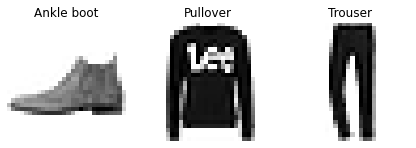

In [62]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

Now you know how to use the Sequential API to build, train, evaluate, and use a classification MLP. But what about regression?

## Building a Regression MLP Using the Sequential API

Let’s switch to the California housing problem and tackle it using a regression neural network. For simplicity, we will use Scikit-Learn’s `fetch_california_housing()` function to load the data. This dataset is simpler than the one we used in Chapter 2, since it contains only numerical features (there is no ocean_proximity feature), and there is no missing value. After loading the data, we split it into a training set, a validation set, and a test set, and we scale all the features:

In [3]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [4]:
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((11610, 8), (3870, 8), (5160, 8), (11610,), (3870,), (5160,))

Using the Sequential API to build, train, evaluate, and use a regression MLP to make predictions is quite similar to what we did for classification. **`The main differences are the fact that the output layer has a single neuron (since we only want to predict a single value) and uses no activation function, and the loss function is the mean squared error. Since the dataset is quite noisy, we just use a single hidden layer with fewer neurons than before, to avoid overfitting:`**

In [18]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])

model.compile(loss='mean_squared_error', optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 3.7216 - val_loss: 0.8862
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.7694 - val_loss: 0.6343
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6361 - val_loss: 0.5848
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6047 - val_loss: 0.5598
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5706 - val_loss: 0.5277
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5558 - val_loss: 0.5022
Epoch 7/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5213 - val_loss: 0.4880
Epoch 8/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5009 - val_loss: 0.4707
Epoch 9/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4922 - val_loss: 0.4580
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4969 - val_loss: 0.4486

In [19]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

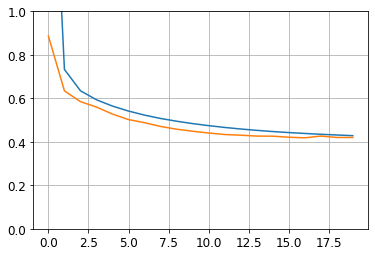

In [25]:
import pandas as pd

plt.plot(pd.DataFrame(history.history))
plt.grid()
plt.gca().set_ylim(0, 1)
plt.show()

In [21]:
y_pred

array([[0.49180704],
       [1.5669572 ],
       [3.2990682 ]], dtype=float32)

In [22]:
y_test[:3]

array([0.477  , 0.458  , 5.00001])

As you can see, the Sequential API is quite easy to use. However, although Sequential models are extremely common, it is sometimes useful to build neural networks with more complex topologies, or with multiple inputs or outputs. For this purpose, Keras offers the Functional API.

## Building Complex Models Using the Functional API

**One example of a `nonsequential neural network` is a Wide & Deep neural network. This neural network architecture was introduced in a 2016 paper by Heng-Tze Cheng et al. It connects all or part of the inputs directly to the output layer, as shown in Figure 10-14. `This architecture makes it possible for the neural network to learn both deep patterns (using the deep path) and simple rules (through the short path). In contrast, a regular MLP forces all the data to flow through the full stack of layers; thus, simple patterns in the data may end up being distorted by this sequence of transformations.`**

![Wide & Deep neural network](images/intro_to_ANN/Wide_and_Deep_neural_network.png)

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network (see [paper](https://ai.google/research/pubs/pub45413)) connects all or part of the inputs directly to the output layer.

In [5]:
np.random.seed(42)
tf.random.set_seed(42)

Let's build such a neural network to tackle the California housing problem:

In [37]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation='relu')(input_)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.Concatenate()([input_, hidden2])
output = keras.layers.Dense(1)(concat)

model = keras.Model(inputs=[input_], outputs=[output])

In [38]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_21 (Dense)                (None, 30)           270         input_6[0][0]                    
__________________________________________________________________________________________________
dense_22 (Dense)                (None, 30)           930         dense_21[0][0]                   
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 38)           0           input_6[0][0]                    
                                                                 dense_22[0][0]             

Let’s go through each line of this code:

* First, we need to create an Input object. This is a specification of the kind of input the model will get, including its $shape$ and $dtype$. A model may actually have multiple inputs, as we will see shortly.

* Next, we create a Dense layer with $30$ neurons, using the ReLU activation function. As soon as it is created, notice that we call it like a function, passing it the input. This is why **`this is called the Functional API`**. Note that we are just telling Keras how it should connect the layers together; no actual data is being processed yet.

* We then create a second hidden layer, and again we use it as a function. Note that we pass it the output of the first hidden layer.

* Next, we create a Concatenate layer, and once again we immediately use it like a function, to concatenate the input and the output of the second hidden layer. You may prefer the `keras.layers.concatenate()` function, which creates a Concatenate layer and immediately calls it with the given inputs.

* Then we create the output layer, with a single neuron and no activation function, and we call it like a function, passing it the result of the concatenation.

* Lastly, we create a Keras Model, specifying which inputs and outputs to use.

In [39]:
model.compile(optimizer=keras.optimizers.SGD(lr=1e-3), loss='mean_squared_error')

In [40]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 3.4702 - val_loss: 4.3885
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.8969 - val_loss: 0.7270
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6746 - val_loss: 0.7715
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6304 - val_loss: 0.6062
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5835 - val_loss: 0.5342
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5549 - val_loss: 0.5969
Epoch 7/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5498 - val_loss: 0.5466
Epoch 8/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5189 - val_loss: 0.4741
Epoch 9/20
363/363 [==============================] - 1s 1ms/step - loss: 0.4992 - val_loss: 0.4812
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4878 - val_loss: 0.4688

In [41]:
mse_test = model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 981us/step - loss: 0.4055


In [42]:
y_pred = model.predict(X_new)

In [43]:
y_pred

array([[0.70039594],
       [1.6432168 ],
       [3.349056  ]], dtype=float32)

In [45]:
y_test[:3]

array([0.477  , 0.458  , 5.00001])

Once you have built the Keras model, everything is exactly like earlier, so there’s no need to repeat it here: you must compile the model, train it, evaluate it, and use it to make predictions.

`But what if you want to send a subset of the features through the wide path and a different subset (possibly overlapping) through the deep path (see Figure 10-15)?` In this case, one solution is to use multiple inputs. For example, suppose we want to send five features through the wide path (features $0$ to $4$), and six features through the deep path (features $2$ to $7$). Note that three features will go through both (features $2$, $3$ and $4$):

In [46]:
np.random.seed(42)
tf.random.set_seed(42)

In [51]:
input_A = keras.layers.Input(shape=[5], name='wide_input')
input_B = keras.layers.Input(shape=[6], name='deep_input')
hidden1 = keras.layers.Dense(30, activation='relu')(input_B)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.Concatenate()([input_A, hidden2])
output = keras.layers.Dense(1, name='output')(concat)
model = keras.Model(inputs=[input_A, input_B], outputs=[output])

In [52]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
deep_input (InputLayer)         [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_30 (Dense)                (None, 30)           210         deep_input[0][0]                 
__________________________________________________________________________________________________
wide_input (InputLayer)         [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_31 (Dense)                (None, 30)           930         dense_30[0][0]                   
____________________________________________________________________________________________

![Handling multiple inputs](images/intro_to_ANN/Handling_multiple_inputs.png)

The code is self-explanatory. `You should name at least the most important layers, especially when the model gets a bit complex like this.` Note that we specified `inputs=[input_A, input_B]` when creating the model. Now we can compile the model as usual, but when we call the `fit()` method, instead of passing a single input matrix `X_train`, we must pass a pair of matrices `(X_train_A, X_train_B)`: one per input. The same is true for `X_valid`, and also for `X_test` and `X_new` when you call `evaluate()` or `predict()`:

In [54]:
model.compile(optimizer=keras.optimizers.SGD(lr=1e-3), loss='mean_squared_error')

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_new[:, :5], X_new[:, 2:]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20, validation_data=((X_valid_A, X_valid_B), y_valid))

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 3.4575 - val_loss: 1.0289
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.8584 - val_loss: 0.6881
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6781 - val_loss: 0.6039
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6172 - val_loss: 0.5446
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5718 - val_loss: 0.5129
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5331 - val_loss: 0.4873
Epoch 7/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5326 - val_loss: 0.4673
Epoch 8/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5015 - val_loss: 0.4499
Epoch 9/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4799 - val_loss: 0.4373
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4678 - val_loss: 0.4269

In [56]:
mse_test = model.evaluate((X_test_A, X_test_B), y_test)

162/162 [==============================] - 0s 933us/step - loss: 0.4183


In [59]:
y_pred = model.predict((X_new_A, X_new_B))

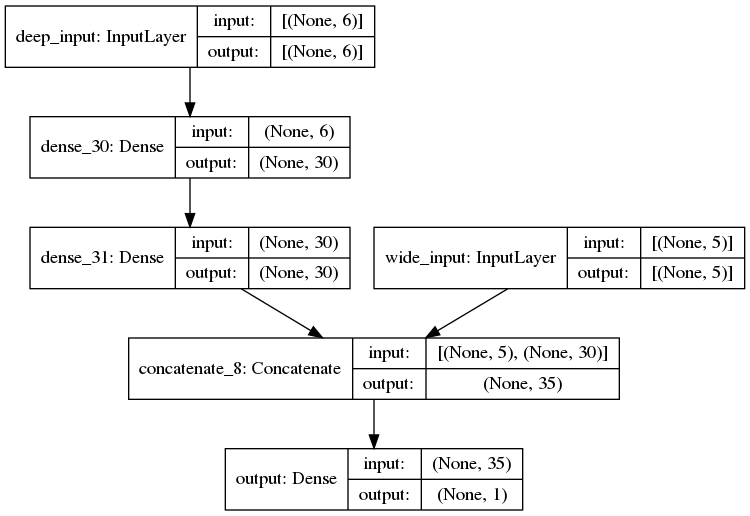

In [64]:
keras.utils.plot_model(model, 'images/intro_to_ANN/handling_multiple_inputs_in_keras.png', show_shapes=True)

There are many use cases in which you may want to have multiple outputs:

* The task may demand it. For instance, you may want to locate and classify the main object in a picture. This is both a regression task (finding the coordinates of the object’s center, as well as its width and height) and a classification task.

* Similarly, you may have multiple independent tasks based on the same data. Sure, you could train one neural network per task, but in many cases you will get better results on all tasks by training a single neural network with one output per task. This is because the neural network can learn features in the data that are useful across tasks. For example, you could perform **`multitask classification`** on pictures of faces, using one output to classify the person’s facial expression (smiling, surprised, etc.) and another output to identify whether they are wearing glasses or not.

* Another use case is as a regularization technique (i.e., a training constraint whose objective is to reduce overfitting and thus improve the model’s ability to generalize). For example, you may want to add some auxiliary outputs in a neural network architecture (see Figure 10-16) to ensure that the underlying part of the network learns something useful on its own, without relying on the rest of the network.

![Handling multiple outputs, in this example to add an auxiliary output for regularization](images/intro_to_ANN/handling_multiple_outputs.png)

Adding extra outputs is quite easy: just connect them to the appropriate layers and add them to your model’s list of outputs. For example, the following code builds the network represented in Figure 10-16:

Adding an auxiliary output for regularization:

In [65]:
np.random.seed(42)
tf.random.set_seed(42)

In [67]:
input_A = keras.layers.Input([5], name='wide_input')
input_B = keras.layers.Input([6], name='deep_input')
hidden1 = keras.layers.Dense(30, activation='relu')(input_B)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.Concatenate()([input_A, hidden2])
output = keras.layers.Dense(1, name='main_output')(concat)
aux_output = keras.layers.Dense(1, name='aux_output')(hidden2)
model = keras.Model(inputs=[input_A, input_B], outputs=[output, aux_output])

In [68]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
deep_input (InputLayer)         [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_34 (Dense)                (None, 30)           210         deep_input[0][0]                 
__________________________________________________________________________________________________
wide_input (InputLayer)         [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_35 (Dense)                (None, 30)           930         dense_34[0][0]                   
____________________________________________________________________________________________

Each output will need its own loss function. Therefore, when we compile the model, we should pass a `list of losses (if we pass a single loss, Keras will assume that the same loss must be used for all outputs).` By default, Keras will compute all these losses and simply add them up to get the final loss used for training. We care much more about the main output than about the auxiliary output (as it is just used for regularization), so we want to give the main output’s loss a much greater weight. Fortunately, it is possible to set all the `loss weights` when compiling the model:

In [70]:
model.compile(optimizer=keras.optimizers.SGD(lr=1e-3), loss=['mse', 'mse'], loss_weights=(0.9, 0.1))

Now when we train the model, we need to provide labels for each output. In this example, the main output and the auxiliary output should try to predict the same thing, so they should use the same labels. So instead of passing *y_train*, we need to pass (*y_train*, *y_train*) (and the same goes for *y_valid* and *y_test*):

In [72]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20, validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Epoch 1/20
363/363 [==============================] - 2s 2ms/step - loss: 3.9702 - main_output_loss: 3.8253 - aux_output_loss: 5.2745 - val_loss: 1.4168 - val_main_output_loss: 1.0005 - val_aux_output_loss: 5.1637
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 1.0911 - main_output_loss: 0.8004 - aux_output_loss: 3.7074 - val_loss: 1.1550 - val_main_output_loss: 0.6406 - val_aux_output_loss: 5.7843
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.8440 - main_output_loss: 0.6580 - aux_output_loss: 2.5183 - val_loss: 1.1336 - val_main_output_loss: 0.5842 - val_aux_output_loss: 6.0785
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.7428 - main_output_loss: 0.6162 - aux_output_loss: 1.8820 - val_loss: 1.0785 - val_main_output_loss: 0.5593 - val_aux_output_loss: 5.7509
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6807 - main_output_loss: 0.5802 - aux_output_loss: 1.5856 - val_loss

When we evaluate the model, Keras will return the total loss, as well as all the individual losses:

In [74]:
total_loss, main_loss, aux_loss = model.evaluate([X_test_A, X_test_B], [y_test, y_test])

162/162 [==============================] - 0s 1ms/step - loss: 0.4802 - main_output_loss: 0.4374 - aux_output_loss: 0.8654


In [75]:
total_loss, main_loss, aux_loss

(0.48019281029701233, 0.43739476799964905, 0.8653754591941833)

Similarly, the *predict()* method will return predictions for each output:

In [76]:
y_pred, y_pred_aux = model.predict([X_new_A, X_new_B])

In [77]:
y_pred, y_pred_aux, y_test[:3]

(array([[0.49311298],
        [1.7884002 ],
        [3.255779  ]], dtype=float32),
 array([[1.2774899],
        [1.8536692],
        [2.6543117]], dtype=float32),
 array([0.477  , 0.458  , 5.00001]))

**`As you can see, you can build any sort of architecture you want quite easily with the Functional API.`** Let’s look at one last way you can build Keras models.

## Using the Subclassing API to Build Dynamic Models

Both the Sequential API and the Functional API are declarative: you start by declaring which layers you want to use and how they should be connected, and only then can you start feeding the model some data for training or inference. This has many advantages: the model can easily be saved, cloned, and shared; its structure can be displayed and analyzed; the framework can infer shapes and check types, so errors can be caught early (i.e., before any data ever goes through the model). It’s also fairly easy to debug, since the whole model is a static graph of layers. But the flip side is just that: it’s static. `Some models involve loops, varying shapes, conditional branching, and other dynamic behaviors. For such cases, or simply if you prefer a more imperative programming style, the Subclassing API is for you.`
<br>

Simply subclass the _Model_ class, create the layers you need in the constructor, and use them to perform the computations you want in the _call()_ method. For example, creating an instance of the following _WideAndDeepModel_ class gives us an equivalent model to the one we just built with the Functional API. You can then compile it, evaluate it, and use it to make predictions, exactly like we just did:

In [53]:
class WideAndDeepModel(keras.Model):
    def __init__(self, units=30, activation='relu', **kwargs):
        super().__init__(**kwargs) # handles standard args (e.g., name)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output
    
model = WideAndDeepModel(30, activation='relu')

In [54]:
model.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=1e-3), loss_weights=[0.9, 0.1])

In [55]:
history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=10, validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))

Epoch 1/10
363/363 [==============================] - 2s 2ms/step - loss: 3.8971 - output_1_loss: 3.6960 - output_2_loss: 5.7076 - val_loss: 4.0827 - val_output_1_loss: 3.6804 - val_output_2_loss: 7.7037
Epoch 2/10
363/363 [==============================] - 1s 2ms/step - loss: 1.2810 - output_1_loss: 0.9430 - output_2_loss: 4.3225 - val_loss: 1.8117 - val_output_1_loss: 0.9127 - val_output_2_loss: 9.9026
Epoch 3/10
363/363 [==============================] - 1s 2ms/step - loss: 0.8913 - output_1_loss: 0.6705 - output_2_loss: 2.8791 - val_loss: 1.6652 - val_output_1_loss: 0.6103 - val_output_2_loss: 11.1593
Epoch 4/10
363/363 [==============================] - 1s 2ms/step - loss: 0.7669 - output_1_loss: 0.6166 - output_2_loss: 2.1194 - val_loss: 1.6267 - val_output_1_loss: 0.5937 - val_output_2_loss: 10.9233
Epoch 5/10
363/363 [==============================] - 1s 2ms/step - loss: 0.6951 - output_1_loss: 0.5736 - output_2_loss: 1.7883 - val_loss: 1.4905 - val_output_1_loss: 0.5594 - val_

In [56]:
model.summary()

Model: "wide_and_deep_model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             multiple                  210       
_________________________________________________________________
dense_32 (Dense)             multiple                  930       
_________________________________________________________________
dense_33 (Dense)             multiple                  36        
_________________________________________________________________
dense_34 (Dense)             multiple                  31        
Total params: 1,207
Trainable params: 1,207
Non-trainable params: 0
_________________________________________________________________


In [57]:
total_loss, main_loss, aux_loss

(0.5382145643234253, 0.45464780926704407, 1.2903153896331787)

In [63]:
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

In [64]:
y_pred_main, y_pred_aux, y_test[:3]

(array([[0.3717559],
        [1.6912112],
        [2.743344 ]], dtype=float32),
 array([[1.2221942],
        [1.3960966],
        [2.066905 ]], dtype=float32),
 array([0.477  , 0.458  , 5.00001]))

In [61]:
model.save_weights('subclass_weights.ckpt')

In [62]:
model.load_weights('subclass_weights.ckpt')

This example looks very much like the Functional API, except we do not need to create the inputs; we just use the input argument to the *call()* method, and we separate the creation of the layers in the constructor from their usage in the *call()* method. **`The big difference is that you can do pretty much anything you want in the call() method: for loops, if statements, low-level TensorFlow operations—your imagination is the limit (see Chapter 12)! This makes it a great API for researchers experimenting with new ideas.`**
<br>

**`This extra flexibility does come at a cost: your model’s architecture is hidden within the call() method, so Keras cannot easily inspect it; it cannot save or clone it; and when you call the summary() method, you only get a list of layers, without any information on how they are connected to each other. Moreover, Keras cannot check types and shapes ahead of time, and it is easier to make mistakes. So unless you really need that extra flexibility, you should probably stick to the Sequential API or the Functional API.`**

### TIP

> Keras models can be used just like regular layers, so you can easily combine them to build complex architectures.

Now that you know how to build and trian neural nets using Keras, you will want to save them!

## Saving and Restoring a Model

When using the Sequential API or the Functional API, saving a trained Keras model is as simple as it gets:

In [32]:
np.random.seed(42)
tf.random.set_seed(42)

In [42]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=[8]),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(1)
])

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 30)                270       
_________________________________________________________________
dense_29 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 31        
Total params: 1,231
Trainable params: 1,231
Non-trainable params: 0
_________________________________________________________________


In [44]:
model.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 1s 2ms/step - loss: 3.1147 - val_loss: 0.8693
Epoch 2/10
363/363 [==============================] - 1s 2ms/step - loss: 0.7992 - val_loss: 0.7331
Epoch 3/10
363/363 [==============================] - 1s 2ms/step - loss: 0.7134 - val_loss: 0.6847
Epoch 4/10
363/363 [==============================] - 1s 2ms/step - loss: 0.6760 - val_loss: 0.6244
Epoch 5/10
363/363 [==============================] - 1s 2ms/step - loss: 0.6230 - val_loss: 0.5886
Epoch 6/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5978 - val_loss: 0.5730
Epoch 7/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5876 - val_loss: 0.5737
Epoch 8/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5518 - val_loss: 0.5308
Epoch 9/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5378 - val_loss: 0.5154
Epoch 10/10
162/162 [==============================] - 0s 930us/step - loss: 0.4906


In [45]:
mse_test

0.49057576060295105

In [46]:
model.save('my_keras_model.h5')

**`Keras will use the HDF5 format to save both the model’s architecture (including every layer’s hyperparameters) and the values of all the model parameters for every layer (e.g., connection weights and biases). It also saves the optimizer (including its hyperparameters and any state it may have).`**
<br>

You will typically have a script that trains a model and saves it, and one or more scripts (or web services) that load the model and use it to make predictions. Loading the model is just as easy:

In [68]:
model = keras.models.load_model('my_keras_model.h5')

In [69]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 30)                270       
_________________________________________________________________
dense_29 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 31        
Total params: 1,231
Trainable params: 1,231
Non-trainable params: 0
_________________________________________________________________


In [73]:
model.predict(X_new)

array([[0.93334347],
       [1.3921258 ],
       [3.0984762 ]], dtype=float32)

### _**WARNING**_

> **This will work when using the Sequential API or the Functional API, but unfortunately not when using model subclassing. You can use `save_weights()` and `load_weights()` to at least save and restore the model parameters, but you will need to save and retore everything else yourself.**

In [71]:
model.save_weights('my_keras_weights.ckpt')

In [72]:
model.load_weights('my_keras_weights.ckpt')

But what if training lasts several hours? This is quite common, especially when training on large datasets. In this case, you should not only save your model at the end of training, but also save checkpoints at regular intervals during training, to avoid losing everything if your computer crashes. But how can you tell the *fit()* method to save checkpoints? Use callbacks.

## Using Callbacks

The *fit()* method accepts a callbacks argument that lets you specify a list of objects that Keras will call at the start and end of training, at the start and end of each epoch, and even before and after processing each batch. For example, the *ModelCheckpoint* callback saves checkpoints of your model at regular intervals during training, by default at the end of each epoch:

In [75]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [76]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

Moreover, if you use a validation set during training, you can set *save_best_only=True* when creating the ModelCheckpoint. In this case, it will only save your model when its performance on the validation set is the best so far. This way, you do not need to worry about training for too long and overfitting the training set: simply restore the last model saved after training, and this will be the best model on the validation set. The following code is a simple way to implement early stopping (introduced in Chapter 4):

In [77]:
model.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint('my_keras_model.h5', save_best_only=True)
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid), callbacks=[checkpoint_cb])
model = keras.models.load_model('my_keras_model.h5') # rollback to best model
mse_test = model.evaluate(X_test, y_test)

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 3.3697 - val_loss: 0.7126
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6964 - val_loss: 0.6880
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6167 - val_loss: 0.5803
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5846 - val_loss: 0.5166
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5321 - val_loss: 0.4895
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5083 - val_loss: 0.4951
Epoch 7/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5044 - val_loss: 0.4861
Epoch 8/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4813 - val_loss: 0.4554
Epoch 9/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4627 - val_loss: 0.4413
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4549 - val_loss: 0.4379

In [78]:
mse_test

0.4003303349018097

Another way to implement early stopping is to simply use the *`EarlyStopping`* callback. It will interrupt training when it measures no progress on the validation set for a number of epochs (defined by the patience argument), and it will optionally roll back to the best model. You can combine both callbacks to save checkpoints of your model (in case your computer crashes) and interrupt training early when there is no more progress (to avoid wasting time and resources):

In [81]:
model.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(restore_best_weights=True, patience=10)
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[early_stopping_cb, checkpoint_cb])
mse_test = model.evaluate(X_test, y_test)

Epoch 1/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3742 - val_loss: 0.3498
Epoch 2/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3713 - val_loss: 0.3734
Epoch 3/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3729 - val_loss: 0.3526
Epoch 4/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3689 - val_loss: 0.3438
Epoch 5/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3659 - val_loss: 0.3462
Epoch 6/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3593 - val_loss: 0.3500
Epoch 7/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3693 - val_loss: 0.3424
Epoch 8/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3651 - val_loss: 0.3407
Epoch 9/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3560 - val_loss: 0.3526
Epoch 10/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3588 - val_lo

In [82]:
mse_test

0.3485163152217865

The number of epochs can be set to a large value since training will stop automatically when there is no more progress. In this case, `there is no need to restore the best model saved because the EarlyStopping callback will keep track of the best weights and restore them for you at the end of training.`

### TIP

> There are many other callbacks available in the [keras.callbacks package](https://keras.io/callbacks/).

**_`If you need extra control, you can easily write your own custom callbacks. As an example of how to do that, the following custom callback will display the ratio between the validation loss and the training loss during training (e.g., to detect overfitting):`_**

In [83]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs['val_loss'] / logs['loss']))

In [85]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid), callbacks=[val_train_ratio_cb])

Epoch 1/5
363/363 [==============================] - 1s 2ms/step - loss: 0.3458 - val_loss: 0.3482

val/train: 1.01
Epoch 2/5
363/363 [==============================] - 1s 2ms/step - loss: 0.3453 - val_loss: 0.3627

val/train: 1.05
Epoch 3/5
363/363 [==============================] - 1s 2ms/step - loss: 0.3448 - val_loss: 0.3436

val/train: 1.00
Epoch 4/5
363/363 [==============================] - 1s 2ms/step - loss: 0.3445 - val_loss: 0.3304

val/train: 0.96
Epoch 5/5
363/363 [==============================] - 1s 2ms/step - loss: 0.3439 - val_loss: 0.3371

val/train: 0.98


_**As you might expect, you can implement `on_train_begin()`, `on_train_end()`, `on_epoch_begin()`, `on_epoch_end()`, `on_batch_begin()`, and `on_batch_end()`. Callbacks can also be used during `evaluation and predictions`, should you ever need them (e.g., `for debugging`). For `evaluation`, you should implement `on_test_begin()`, `on_test_end()`, `on_test_batch_begin()`, or `on_test_batch_end()` (called by `evaluate()`), and for `prediction` you should implement `on_predict_begin()`, `on_predict_end()`, `on_predict_batch_begin()`, or `on_predict_batch_end()` (called by `predict()`).**_

Now let’s take a look at one more tool you should definitely have in your toolbox when using tf.keras: TensorBoard.

## Using TensorBoard for Visualization